In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mglearn
%matplotlib inline
import seaborn as sns
import platform
from matplotlib import font_manager , rc

if platform.system() == 'Darwin':
  rc('font' , family = 'AppleGothic')
elif platform.system() == 'Windows':
  path = 'C:/Windows/Fonts/malgun.ttf'
  font_name = font_manager.FontProperties(fname = path).get_name()
  rc('font' , family = font_name)
else:
  print('모름')
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings('ignore')

In [2]:
#필요한 모델들
from sklearn.ensemble import RandomForestRegressor , RandomForestClassifier
from sklearn.linear_model import LinearRegression , Ridge , LogisticRegression
from sklearn.model_selection import GridSearchCV , train_test_split , cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score , classification_report , confusion_matrix , accuracy_score , f1_score , roc_curve, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 문제 정의
 - 수질 지표의 지수에 따라 이 물이 먹어도 되는지 안되는지에 대해 판단하기

## 데이터셋 로딩

In [3]:
data = pd.read_csv('water_potability.csv')

## 데이터 탐색

- pH: 물의 pH 수준.
- Hardness: 물의 경도, 미네랄 함량의 척도
- Solids: 물에 용해된 총 고형물
- Chloramines: 물 속의 클로라민 농도.
- Sulfate: 물 속의 황산염 농도.
- Conductivity: 물의 전기 전도도.
- Organic_carbon: 물 속 유기탄소 함량.
- Trihalomethanes: 물 속의 트리할로메탄 농도.
- Turbidity: 탁도 수준, 물의 투명도를 나타내는 척도.
- Potability: target(0 : 불가 , 1: 가능)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


- 결측치가 많음.

- 복사본 생성

In [5]:
data1 = data.dropna(axis = 0)

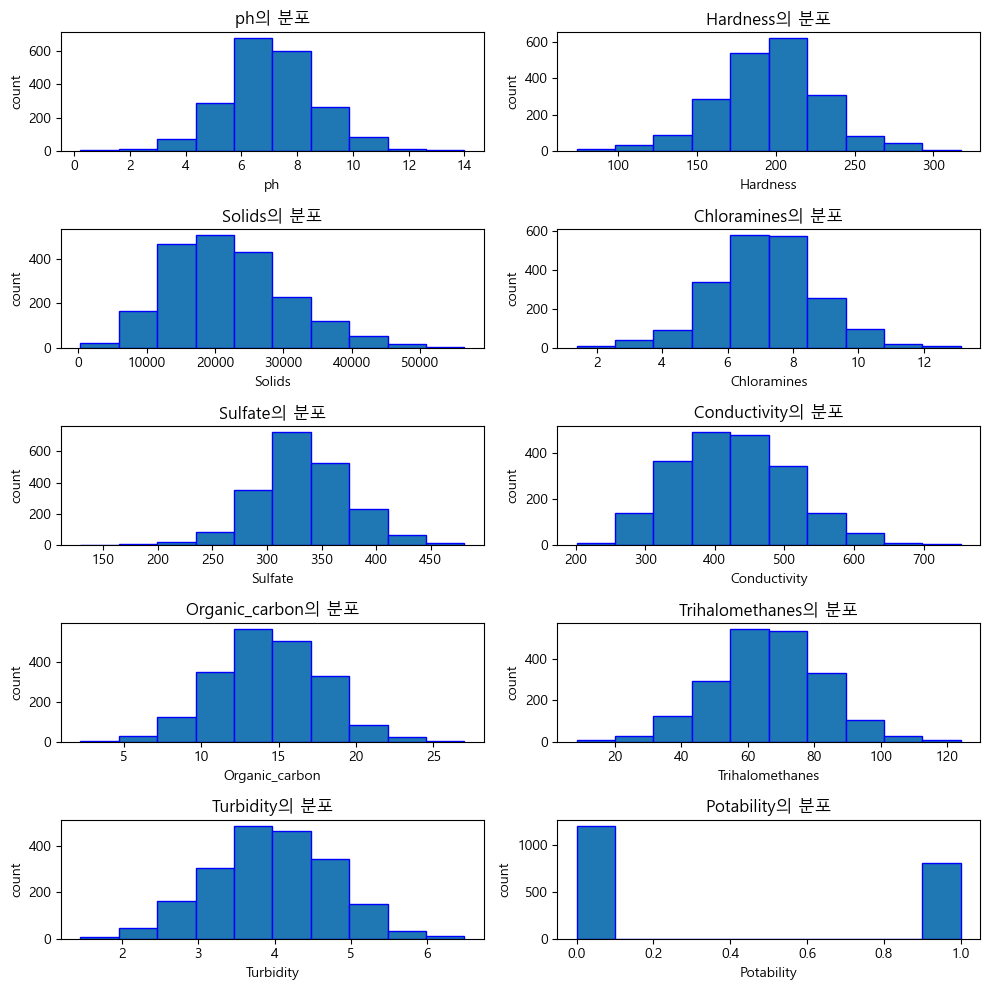

In [6]:
plt.figure(figsize = (10,10))
for i , col in enumerate(data1.columns):
    plt.subplot(5,2,i+1)
    data1[col].plot(kind = 'hist' , edgecolor = 'b')
    plt.title(f'{col}의 분포')
    plt.xlabel(col)
    plt.ylabel('count')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize = (20,20))
sns.pairplot(data1 , hue = 'Potability')

<Figure size 2000x2000 with 0 Axes>

<Axes: >

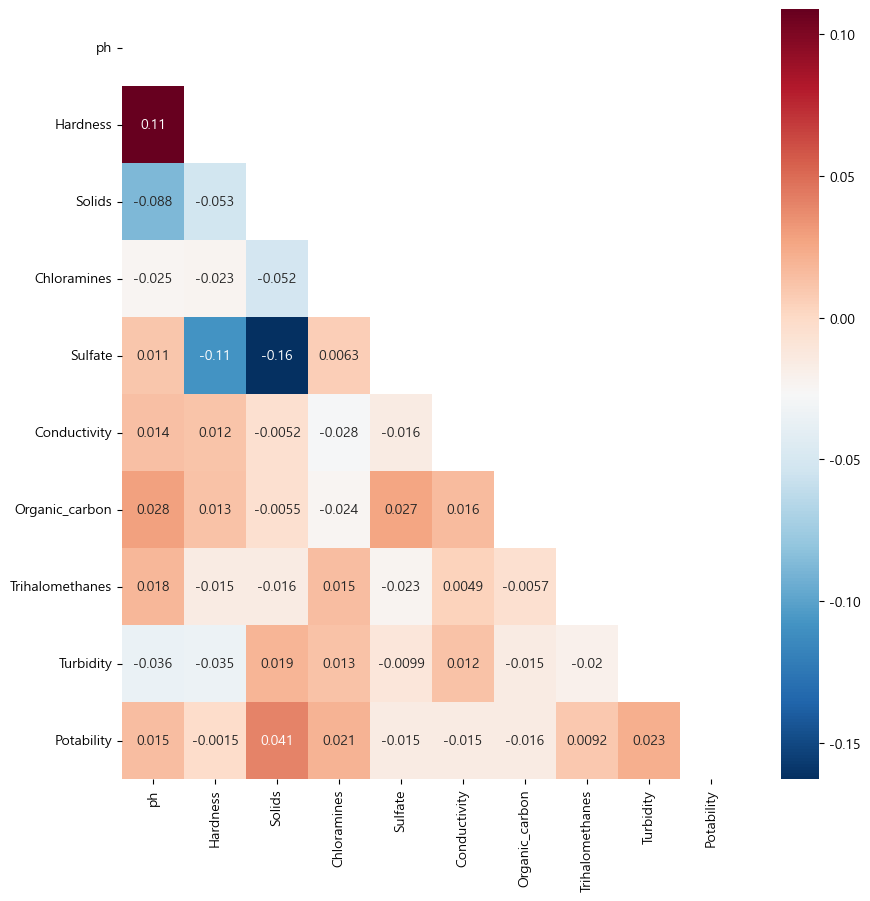

In [7]:
mask = np.triu(np.ones_like(data1.corr()))
plt.figure(figsize = (10,10))
sns.heatmap(data1.corr() , annot = True , cmap = 'RdBu_r' , mask = mask)

- 성능 내기가 상당히 어려워보인다.

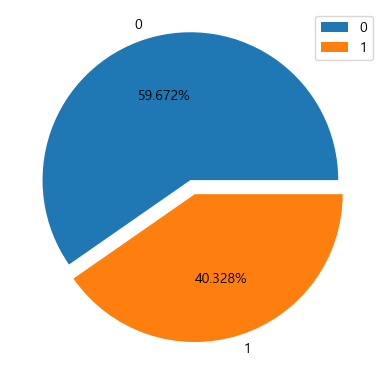

In [8]:
plt.pie(data1.Potability.value_counts() ,labels=data.Potability.unique() ,  autopct='%.3f%%' , explode = [0.1,0])
plt.legend()
plt.show()

In [9]:
data_null = data[data.ph.isna()|data.Sulfate.isna()|data.Trihalomethanes.isna()]

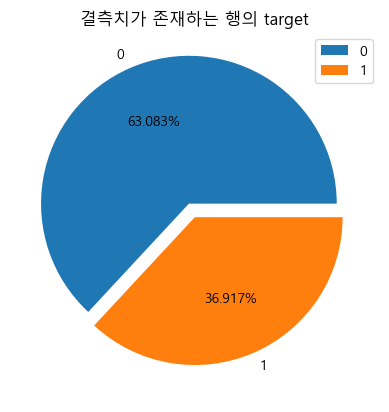

In [10]:
plt.pie(data_null.Potability.value_counts() ,labels=data.Potability.unique() ,  autopct='%.3f%%' , explode = [0.1,0])
plt.legend()
plt.title('결측치가 존재하는 행의 target')
plt.show()

- ph의 결측값은 ph의 평균값으로 대체

In [11]:
df = data.copy()
df.dropna(subset = ['ph'] , inplace = True)

In [12]:
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [13]:
data.ph.fillna(df.ph.mean() , inplace = True)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               3276 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


- Trihalomethanes : 물 속의 트리할로메탄 농도
- Conductivity: 물의 전기 전도도.

- 할로메탄이란?
 - 염소 소독시 발생하는 발암물질이다.

- 위 두 개의 변수의 결측치를 채우기 위해 모델학습 이용

In [15]:
data.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

## 결측치가 있는 행을 제거한 후 , 거기에서 채울 열을 제거해서 학습시킬 데이터 생성

In [16]:
fill_Tri = data.dropna(subset = ['Trihalomethanes']).drop(['Trihalomethanes' , 'Potability' , 'Sulfate'] , axis = 1)
fill_Tri_target = data.dropna(subset = ['Trihalomethanes'])['Trihalomethanes']

In [17]:
fill_Tri.shape , fill_Tri_target.shape

((3114, 7), (3114,))

In [18]:
fill_target = data[data.Trihalomethanes.isna()].dropna(axis = 1).drop('Potability' , axis = 1)

In [19]:
fill_target.shape

(162, 7)

## 결측치 채우는 함수 정의

In [20]:
def standard(fit_model , transform_model):
    ss = StandardScaler()
    ss.fit(fit_model)
    return ss.transform(transform_model)

In [21]:
fill_Tri_scaled = standard(fill_Tri , fill_Tri)
fill_target_scaled = standard(fill_Tri , fill_target)

In [22]:
def grid(model , train_input , train_target):
    params = {'RandomForestRegressor' : { 'n_estimators' : [10, 100],
                                         'max_depth' : [6, 8, 10],
                                         'min_samples_leaf' : [8, 12],
                                         'min_samples_split' : [8, 16]},
              'Ridge' : {'alpha' : [0.001,0.01,0.1,1,10]},
              'LinearRegression' : {'n_jobs' : [1,-1]},
              'SVC' : {'C' : [0.001 , 0.01 , 0.1 , 1],
                       'kernel' : ['poly','rbf'],
                       'gamma' : [0.0001 , 0.001 , 0.01 , 0.1]},
              'RandomForestClassifier' : { 'n_estimators' : [10, 100],
                                          'max_depth' : [6, 8, 10],
                                          'min_samples_leaf' : [8, 12],
                                          'min_samples_split' : [8, 16]}
             }
    model_best = []
    for i in model:
        gs = GridSearchCV(i , params[i.__class__.__name__] , cv = 10)
        gs.fit(train_input , train_target)
        model_best.append(gs.best_estimator_)
    return model_best

In [ ]:
model = [Ridge(random_state = 42) , RandomForestRegressor(random_state = 42) , LinearRegression()]
best_model = grid(model , fill_Tri_scaled , fill_Tri_target)

In [ ]:
best_model

In [ ]:
def fit(model , data , target , fill_target):
    model.fit(data , target)
    return model.predict(fill_target)

## 3개의 모델로 학습시켜서 예측한 값을 result에 저장하고 , 3개의 값의 평균으로 결측치 대체

In [ ]:
result = []
for i in best_model:
    result.append(fit(i , fill_Tri_scaled , fill_Tri_target , fill_target_scaled))

In [ ]:
Tri_fill = np.mean(result , axis = 0)

In [ ]:
data.loc[data['Trihalomethanes'].isna(), 'Trihalomethanes'] = Tri_fill

In [ ]:
data.info()

In [ ]:
fill_Sul = data.dropna(subset = ['Sulfate']).drop(['Potability' , 'Sulfate'] , axis = 1)
fill_Sul_target = data.dropna(subset = ['Sulfate'])['Sulfate']

In [ ]:
fill_Sul.shape , fill_Sul_target.shape

In [ ]:
fill_target_Sul = data[data.Sulfate.isna()].dropna(axis = 1).drop('Potability' , axis = 1)

In [ ]:
fill_Sul_scaled = standard(fill_Sul , fill_Sul)
fill_target_Sul_scaled = standard(fill_Sul , fill_target_Sul)

In [ ]:
model = [Ridge(random_state = 42) , RandomForestRegressor(random_state = 42) , LinearRegression()]
best_model = grid(model , fill_Sul_scaled , fill_Sul_target)

In [ ]:
best_model

In [ ]:
Sulfate = []

for i in best_model:
    Sulfate.append(fit(i , fill_Sul_scaled , fill_Sul_target , fill_target_Sul_scaled))

In [ ]:
Sul_fill = np.mean(Sulfate , axis = 0)

In [ ]:
data.loc[data['Sulfate'].isna(), 'Sulfate'] = Sul_fill

In [ ]:
data.info()

- 결측치 대체 완료

In [ ]:
data.Potability.value_counts()

In [ ]:
plt.pie(data.Potability.value_counts() ,labels=data.Potability.unique() ,  autopct='%.3f%%' , explode = [0.1,0])
plt.legend()
plt.show()

## 학습 데이터와 테스트 데이터로 나누고 , StandScaler를 이용한 정규화

In [ ]:
def divide(x , y):
    train_input , test_input , train_target , test_target = train_test_split(x , y , test_size = 0.2 , stratify = y , random_state = 42)
    ss = StandardScaler()
    train_scaled = ss.fit_transform(train_input)
    test_scaled = ss.transform(test_input)
    
    return train_scaled , test_scaled , train_target , test_target

In [ ]:
train_input , test_input , train_target , test_target =divide(data.iloc[:,:-1] , data.iloc[:,-1])

In [ ]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(train_input , train_target)
print(classification_report(test_target , rf.predict(test_input)))

## 교차검증

In [ ]:
scores = cross_validate(rf , train_input , train_target , cv = 10 , scoring = 'precision')
np.mean(scores['test_score'])

In [ ]:
scores = cross_validate(rf , train_input , train_target , cv = 10)
np.mean(scores['test_score'])

## 특성공학을 이용하여 feature의 개수 늘리기

In [ ]:

def poly(train_input , test_input):
    poly = PF(include_bias = False)
    train_poly = poly.fit_transform(train_input)
    test_poly = poly.transform(test_input)
    return train_poly , test_poly

In [ ]:
train_poly , test_poly = poly(train_input, test_input)

In [ ]:
train_poly.shape , train_input.shape

- 특성이 늘어남.

In [ ]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(train_poly , train_target)
print(classification_report(test_target , rf.predict(test_poly)))

- 효과가 미미하다.

## 모든 분류모델을 써서 '정밀도'를 측정해보기

In [ ]:
data.describe().T

In [ ]:
kn = KNeighborsClassifier()
lr = LogisticRegression(random_state = 42)
rf = RandomForestClassifier(random_state = 42)
svc = SVC(random_state = 42)
xgb = XGBClassifier(random_state = 42)
lgb = LGBMClassifier(random_state = 42)


model = [kn,lr,rf,svc,xgb,lgb]

In [ ]:
#정확도 , 정밀도를 측정
def add_precision(model):
    names.append(model.__class__.__name__)
    model.fit(train_input , train_target)
    precision.append(precision_score(test_target , model.predict(test_input)))
    accuracy.append(accuracy_score(test_target , model.predict(test_input)))

In [ ]:
x = data.iloc[:,:-1]
y = data.iloc[:,-1]

train_input , test_input , train_target , test_target = divide(x , y)

In [ ]:
names = []
precision = []
accuracy = []
for i in model:
    add_precision(i)

In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(2,1,1)
plt.barh(names , precision , color=plt.cm.viridis(precision))
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(precision), vmax=max(precision)))
cbar = plt.colorbar(sm)

for i, val in enumerate(precision):
    plt.text(val, i, f'{val:.2f}', va='center')
    
plt.xlabel('precision(정밀도)')
plt.ylabel('model(모델 이름)')
plt.title('모델별 정밀도')

plt.subplot(2,1,2)
plt.barh(names , accuracy , color=plt.cm.viridis(accuracy))
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(accuracy), vmax=max(accuracy)))
cbar = plt.colorbar(sm)
for i, val in enumerate(accuracy):
    plt.text(val, i, f'{val:.2f}', va='center')
    
plt.xlabel('accuracy(정확도)')
plt.ylabel('model(모델 이름)')
plt.title('모델별 정확도')


plt.tight_layout()

plt.show()

## 정밀도가 중요하다고 판단 , 정밀도를 올리는 방향

### SVM

In [ ]:
train_poly , test_poly = poly(train_input, test_input)

In [ ]:
svc.fit(train_poly , train_target)

In [ ]:
def text(plot):
    for i in plot:
        height = i.get_height()
        plt.text(i.get_x()+i.get_width()/2.0,height,  round(height, 2) ,  ha = 'center',va='bottom',size=12)

In [ ]:
def poly_comparison(model , train_input , test_input):
    train_poly , test_poly = poly(train_input , test_input)
    p_list = ['No' , 'Yes']
    prec = []
    accu = []
    model.fit(train_input , train_target)
    prec.append(precision_score(test_target , model.predict(test_input)))
    accu.append(accuracy_score(test_target , model.predict(test_input)))
    
    model.fit(train_poly , train_target)
    prec.append(precision_score(test_target , model.predict(test_poly)))
    accu.append(accuracy_score(test_target , model.predict(test_poly)))
    
    plt.figure(figsize = (10,5))
    width = 0.2
    pre = plt.bar(np.arange(len(p_list))-width/2 , prec ,width = width , color = 'r' , label = 'precision')
    acc = plt.bar(np.arange(len(p_list))+width/2 , accu ,width = width , color = 'k' , label = 'accuracy')
    plt.xticks(np.arange(len(p_list)) , p_list)
    plt.legend(loc = 'upper center')
    plt.xlabel('특성공학 여부')
    plt.ylim(0.6 , 0.7)
    plt.ylabel('수치')
    plt.title('특성공학 여부에 따른 정확도와 정밀도')
    for i in [pre , acc]:
        text(i)
    plt.show()

In [ ]:
poly_comparison(svc , train_input , test_input)

In [ ]:
svc_best = grid([SVC(random_state = 42 , probability=True)] , train_input , train_target)
svc_best

In [ ]:
svc_best = svc_best[0]

In [ ]:
svc_best.fit(train_input , train_target)

In [ ]:
pred = svc_best.decision_function(test_input)

In [ ]:
confusion_matrix(test_target , svc_best.predict(test_input))

In [ ]:
print(classification_report(test_target , svc_best.predict(test_input)))

In [ ]:
svc_best.predict_proba(test_input)

In [ ]:
def proba(model):
    fper , tper , thresholds = roc_curve(test_target , model.predict_proba(test_input)[:,1])
    return fper , tper , thresholds

In [ ]:
fper , tper , thresholds = proba(svc_best)

In [ ]:
roc_auc_score(test_target , svc_best.predict_proba(test_input)[:,1])

In [ ]:
plt.plot(fper , tper)
plt.scatter(0,1 , color = 'red')
plt.plot([0,1] , [0,1] , ls = '--')
plt.show()

- x축 : 정답이 Negative(0)인 것 중에서 모델이 Positive라고 잘못 예측한 것의 비율이 된다.
- y축 : 정답이 Positive(1)인 것들 중에서 정말로 정답을 맞춘 수의 비율이 된다. (재현율)

### RandomForestClassification

In [ ]:
rf_best = grid([RandomForestClassifier(random_state = 42)] , train_input , train_target)

In [ ]:
rf_best = rf_best[0]

In [ ]:
rf_best.fit(train_input , train_target)

In [ ]:
rf_best.predict_proba(test_input)

In [ ]:
print(classification_report(test_target , rf_best.predict(test_input)))

In [ ]:
imp = rf_best.feature_importances_

In [ ]:
imp2 = []
for i in imp:
    imp2.append(round(i , 3))

In [ ]:
col = data.columns[:-1]

In [ ]:
feature = dict(zip(col , imp2))

In [ ]:
feature

In [ ]:
fper , tper , thresholds = proba(rf_best)

In [ ]:
roc_auc_score(test_target , rf_best.predict_proba(test_input)[:,1])

In [ ]:
plt.plot(fper , tper)
plt.scatter(0,1 , color = 'red')
plt.plot([0,1] , [0,1] , ls = '--')

In [ ]:
def acc_pred(model):
    try:
        thresholds_list = [0.1,0.2,0.3,0.4 , 0.5]
        pred = model.decision_function(test_input)
    except:
        thresholds_list = [0.4,0.45,0.5,0.55,0.6]
        pred = model.predict_proba(test_input)[:,1]
    


    accuracy_list = []
    precision_list = []
    for i in thresholds_list:
        y_pred = np.where(pred>i , 1 , 0)
        acc = accuracy_score(test_target , y_pred)
        precision = precision_score(test_target , y_pred)
        accuracy_list.append(acc)
        precision_list.append(precision)
#         print(f'임계값 : {i}')
#         print(f'정확도 : {acc:.4f}\n정밀도 : {precision:.4f}')
#         print()
    return thresholds_list , accuracy_list , precision_list

In [ ]:
def plotting(model1 , model2):
    thresholds_list , accuracy_list , precision_list = acc_pred(model1)
    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    width = 0.3
    acc = plt.bar(np.arange(len(thresholds_list)) - width/2 , accuracy_list ,width = width ,  color = 'r' , label = '정확도')
    pre = plt.bar(np.arange(len(thresholds_list)) + width/2 , precision_list ,width = width ,  color = 'b' , label = '정밀도')

    for i in [acc , pre]:
        text(i)


    plt.xticks(np.arange(len(thresholds_list)) , thresholds_list)
    plt.xlabel('임계값')
    plt.ylabel('수치')
    plt.title(f'임계값 별 정밀도와 정확도({model1.__class__.__name__})')
    plt.legend(loc = 'upper center')
    plt.ylim(0.6 , 0.9)
    
    plt.subplot(1,2,2)
    thresholds_list , accuracy_list , precision_list = acc_pred(model2)
    width = 0.3
    acc = plt.bar(np.arange(len(thresholds_list)) - width/2 , accuracy_list ,width = width ,  color = 'r' , label = '정확도')
    pre = plt.bar(np.arange(len(thresholds_list)) + width/2 , precision_list ,width = width ,  color = 'b' , label = '정밀도')

    for i in [acc , pre]:
        text(i)


    plt.xticks(np.arange(len(thresholds_list)) , thresholds_list)
    plt.xlabel('임계값')
    plt.ylabel('수치')
    plt.title(f'임계값 별 정밀도와 정확도({model2.__class__.__name__})')
    plt.legend(loc = 'upper center')
    plt.ylim(0.5 , 0.9)

In [ ]:
plotting(svc_best , rf_best)

# 결론

In [ ]:
print('SVC')
for i in [0.4, 0.5]:
    predic = np.where(svc_best.decision_function(test_input)>i , 1 , 0)
    print(f'임계값 : {i}')
    print(confusion_matrix(test_target , predic))
    print()
    
print('RandomForest')
for i in [0.55 , 0.6]:
    predic = np.where(rf_best.predict_proba(test_input)[:,1] > i , 1 , 0)
    print(f'임계값 : {i}')
    print(confusion_matrix(test_target , predic))
    print()

- TP가 가장 많은 것 채택

In [ ]:
prediction = np.where(svc_best.decision_function(test_input) > 0.4 , 1 , 0)

In [ ]:
print(classification_report(test_target , prediction))

- 정확도를 적당히 잃으면서 정밀도를 끌어올렸다.